## Assignment #1 Face Recognition

In [1]:
import cv2 as cv
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. Download the Dataset and Understand the Format

In [3]:
# Initialize an empty dictionary to store the loaded images
faces = {}

# Open the Zip archive and iterate over the files
with zipfile.ZipFile("archive.zip") as folder:
    for filename in folder.namelist():

        # Check if the file is a PGM image
        if filename.endswith('.pgm'):

            # Open the file and read its contents into a buffer
            with folder.open(filename) as image:
                arr = np.frombuffer(image.read(), np.uint8)

            # Decode the buffer as a grayscale image using OpenCV
            # and store it in the dictionary
            faces[filename] = cv.imdecode(arr, cv.IMREAD_GRAYSCALE)

In [4]:
faces['s12/8.pgm'].shape

(112, 92)

In [5]:
file_names = list(faces.keys())
print(file_names[:5])

['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm']


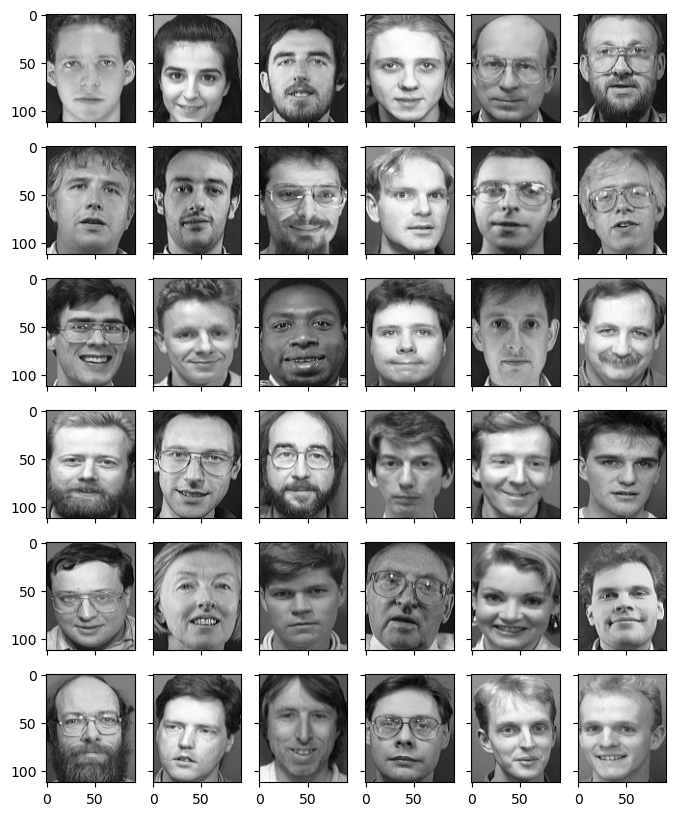

In [6]:
# Create a figure with a 6x6 grid of subplots that share the same x and y axes
figure, axis = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8, 10))

# Initialize an empty list to store the images to plot, 10 steps each time to cover as many faces as possible
images = []
for i in range(36):
    images.append(list(faces.values())[i * 10])
for i in range(36):
    row = i // 6
    col = i % 6
    axis[row][col].imshow(images[i], cmap='gray')
plt.show()

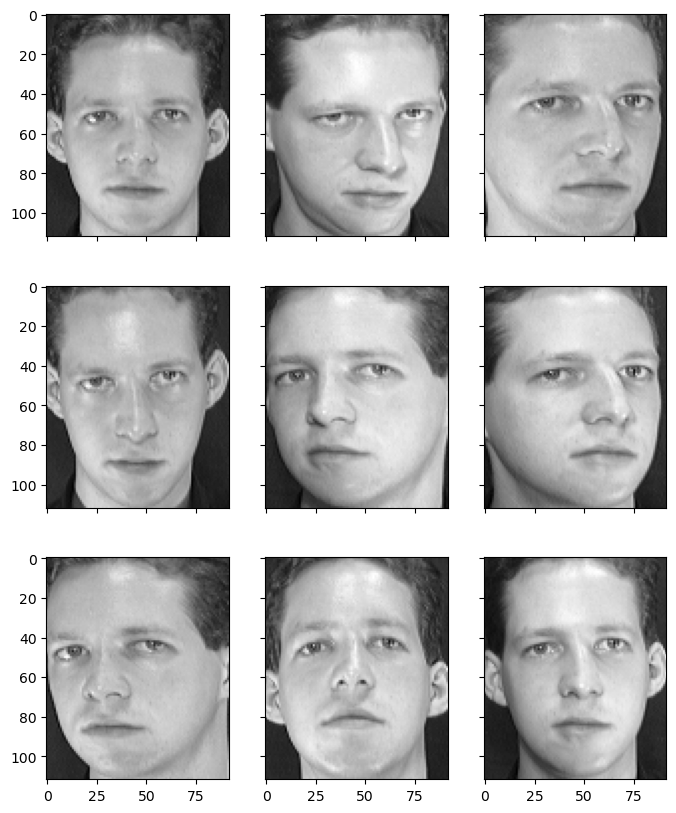

In [7]:
figure, axis = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8, 10))
images = []
for i in range(9):
    images.append(list(faces.values())[i])

# Display 9 images for the same subject to get an idea of how data looks like
for i in range(9):
    row = i // 3
    col = i % 3
    axis[row][col].imshow(images[i], cmap='gray')
plt.show()

### 2. Generate the Data Matrix and the Label vector

In [8]:
#Get the dimensions of the grayscale image
n_x = faces[file_names[0]].shape[0]
n_y = faces[file_names[0]].shape[1]

#Initialize the data matrix array to stack the samples
data = np.empty((n_x*n_y, 0))

#Initialize list of classes
label = []
for i in range(len(faces.keys())):
    faces[file_names[i]]=faces[file_names[i]].reshape(n_x*n_y,1)
    data = np.hstack((data,faces[file_names[i]]))
    label.append(file_names[i].split("/")[0][1:])
label = np.array(label).reshape((400,1))

In [9]:
data.shape

(10304, 400)

In [10]:
label.shape

(400, 1)

### 3. Split the Dataset into Training and Testing Test sets

In [11]:
#Split the Dataset, even rows for testing and odd for training
test_x = data.T[::2]
test_y = label[::2]
train_x = data.T[1::2]
train_y = label[1::2]

In [12]:
test_x.shape

(200, 10304)

In [13]:
test_y.shape

(200, 1)

In [14]:
train_x.shape

(200, 10304)

In [15]:
train_y.shape

(200, 1)

### 4. Classification using PCA

<img src="pca.png" width="80%" height="80%" />


In [145]:
alpha = [0.8,0.85,0.9,0.95]

In [146]:
mu = np.mean(train_x,axis=0,keepdims=True)
mu.shape

(1, 10304)

In [147]:
Z = train_x - mu
Z.shape

(200, 10304)

In [148]:
cov = np.matmul(Z.T,Z)
cov /= Z.shape[0]
cov.shape

(10304, 10304)

In [149]:
eigen_values, eigen_vectors = np.linalg.eigh(cov)

In [150]:
#Sort eigen vectors according to the descending order of corresponding eigen values
idx = eigen_values.argsort()[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

In [151]:
sum_eigen = float(np.sum(eigen_values))

In [154]:
#Choose the number of eigen vectors in the eigen face according to the accuracy we defined, we have an array alphas of all
#accuracies desired, we return a corresponding array with the number of eigen vectors starting from 0
var = 0
num_eigen = 0
final_rank = []
temp_sum = 0
for i in alpha:
    while var < i:
        temp_sum += eigen_values[num_eigen]
        var = temp_sum/sum_eigen
        num_eigen += 1
    final_rank.append(num_eigen)
    var=0
    num_eigen=0
    temp_sum=0
print(final_rank)

[36, 52, 76, 117]


In [155]:
for i in final_rank:
    print(sum(eigen_values[:i])/sum_eigen)

0.8013424991514233
0.8512997691218919
0.9001854332073955
0.9508770792642043


In [156]:
projection = eigen_vectors[:,:final_rank[0]]
projection

array([[ 0.00057275, -0.01413327, -0.01741753, ..., -0.00681658,
         0.00394548, -0.00121975],
       [ 0.00056017, -0.01408193, -0.0175307 , ..., -0.00369059,
         0.00246578, -0.00158265],
       [ 0.00036015, -0.01400357, -0.01726062, ..., -0.0048471 ,
         0.00251487, -0.00116721],
       ...,
       [ 0.00664655,  0.00976511, -0.01803849, ..., -0.01695389,
         0.00510755,  0.01022495],
       [ 0.00598777,  0.00978134, -0.01697895, ..., -0.01791087,
         0.00699513,  0.01400393],
       [ 0.00698216,  0.00973784, -0.01691825, ..., -0.02056177,
         0.01498101,  0.01202104]])

In [157]:
train_x.shape

(200, 10304)

In [158]:
projection.shape

(10304, 36)

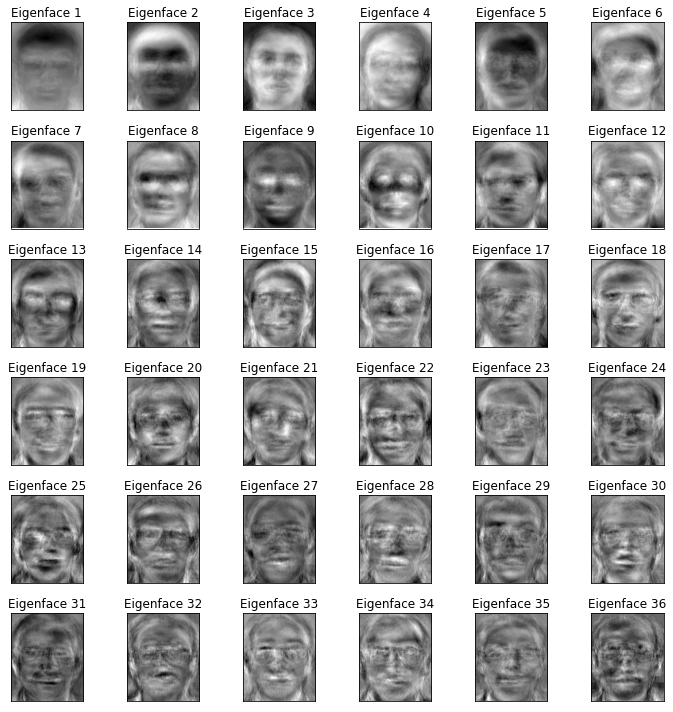

In [161]:
# Plot the eigenfaces
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        index = i * 6 + j
        eigenface = eigen_vectors[:, index]
        col.imshow(eigenface.reshape(112, -1), cmap='gray')
        col.set_xticks([])
        col.set_yticks([])
        col.set_title(f"Eigenface {index+1}")
fig.tight_layout()
plt.show()

In [162]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def classify_knn(train_x, train_y, test_x, test_y, k=1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x, train_y)
    accuracy = knn.score(test_x, test_y)
    return accuracy

In [106]:
print(f'K = 1')
accuracy = {}
for i in range(len(final_rank)):
    projection = eigen_vectors[:,:final_rank[i]]
    train_x_new= np.dot(train_x,projection)
    test_x_new= np.dot(test_x,projection)
    org_accuracy = classify_knn(train_x_new, train_y, test_x_new, test_y, k=1)
    accuracy[alpha[i]] = org_accuracy
print(accuracy)

K = 1
{0.8: 0.94, 0.85: 0.945, 0.9: 0.94, 0.95: 0.935}


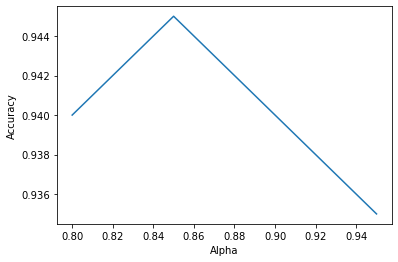

In [107]:
x = accuracy.keys()
y = accuracy.values()
plt.plot(x, y)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

In [57]:
KNN = [1,3,5,7]
for j in range(4):
    print(f'K = {KNN[j]}')
    accuracy = {}
    for i in range(len(final_rank)):
        projection = eigen_vectors[:,:final_rank[i]]
        train_x_new= np.dot(train_x,projection)
        test_x_new= np.dot(test_x,projection)
        org_accuracy = classify_knn(train_x_new, train_y, test_x_new, test_y, k=KNN[j])
        accuracy[alpha[i]] = org_accuracy
    print(accuracy)

K = 1
{0.8: 0.94, 0.85: 0.945, 0.9: 0.94, 0.95: 0.935}
K = 3
{0.8: 0.84, 0.85: 0.86, 0.9: 0.875, 0.95: 0.885}
K = 5
{0.8: 0.815, 0.85: 0.795, 0.9: 0.8, 0.95: 0.785}
K = 7
{0.8: 0.765, 0.85: 0.785, 0.9: 0.765, 0.95: 0.775}


In [1]:
# testing

In [ ]:
# adeny geeeeeeeet